# Outline
- [1. Imports](#1)
- [2. Distribution Strategy](#2)
- [3. Loading the Competition Data](#3)
- [4. Datasets functions](#4)
- [5. Random erasing (blockout) augmentation](#5)
- [6. Create Data Pipelines](#6)
- [7. Datasets visualization](#7)
- [8. Define and Training Model](#8)
- [9. Evaluate Predictions](#9)
- [10. Make Test Predictions](#10)

<a name="1"></a>
# 1. Imports #

We begin by importing several Python packages.

In [1]:
!pip install -q efficientnet


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import math, re, os
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, \
                            recall_score, confusion_matrix

import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras import applications as tf_app

from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, EarlyStopping

from kaggle_datasets import KaggleDatasets

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.14.0


/usr/local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


<a name="2"></a>
# 2. Distribution Strategy #

A TPU has eig We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. The following cell creates the distribution strategy that we'll later apply to our model. We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different *replicas* of the model, one for each core.

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-11-10 00:58:56.980008: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:58:56.980136: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:58:56.980219: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:58:56.980300: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:58:56.980365: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:58:56.980563: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:58:56.980640: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


<a name="3"></a>
# 3. Loading the Competition Data #

For convenience in changing the required parameters during model training, we can set them here

In [4]:
SEED = 20
EPOCHS = 30
IMAGE_SIZE = [512, 512] # 192, 224, 331, 512
aug_flip = True
aug_erase = True
RL = 0.4   # erasure area (for aug_erase=True)
P = 0.3    # erasure frequency (for aug_erase=True)
OPTIMIZER = 'nadam' # 'adam', 'nadam'
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
MAX_LR = 0.00005 * strategy.num_replicas_in_sync

net_type = tf_app               # tf_app, efn
model_type = 'Xception'      # 'Xception', 'DenseNet201' ('EfficientNetB7' for efn)
model_weights = 'imagenet'      # 'imagenet' ('noisy-student' for efn)

## Get GCS Path ##

When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). We can use data from any public GCS bucket by giving its path just like we would data from `'/kaggle/input'`. The following will retrieve the GCS path for this competition's dataset.

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
GCS_DS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
print(GCS_DS_PATH)
print(GCS_DS_PATH_EXT)

/kaggle/input/tpu-getting-started
/kaggle/input/tf-flower-photo-tfrec


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started
get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tf-flower-photo-tfrec


## Load Data and count data items ##

When used with [TPUs](https://www.kaggle.com/docs/tpu), datasets are often serialized into [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics). This is a format convenient for distributing data to each of the TPUs cores.

In [6]:
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

IMAGENET_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/imagenet' + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/inaturalist' + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/openimage' + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/oxford_102' + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/tf_flowers' + '/*.tfrec')

ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES  

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + ADDITIONAL_TRAINING_FILENAMES
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


<a name="4"></a>
# 4. Datasets functions #

In [7]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

<a name="5"></a>
# 5. Random erasing (blockout) augmentation #

In [8]:
def random_erasing(img, sl=0.1, sh=0.2, rl=RL, p=P):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32, seed=SEED)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32, seed=SEED)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32, seed=SEED)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32, seed=SEED)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1, seed=SEED) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

The `random_erasing` function appears to be implementing the "Random Erasing" data augmentation technique for images. It generates an augmented version of an input image by randomly erasing a rectangular or square region within the image with a certain probability. Here's a breakdown of what this function does:

1. Calculate the height (`h`), width (`w`), and number of channels (`c`) of the input image `img`.

2. Determine the area of the original image `origin_area` (product of `h` and `w`).

3. Calculate the lower and upper limits for the size of the erasing region:
   - `e_size_l`: The lower limit is determined by scaling a small value (`sl`) with respect to the original image area and a "regularization factor" (`rl`). It's rounded to the nearest integer.
   - `e_size_h`: The upper limit is calculated similarly using `sh` and `rl`.

4. Generate random values for the height and width of the erasing region:
   - `erase_height`: Randomly selected height for erasing, bounded by the limits `e_size_l` and `e_height_h`.
   - `erase_width`: Randomly selected width for erasing, bounded by the same limits.

5. Create an erase area with the selected height and width. This area is initially filled with zeros.

6. Calculate the amount of padding required around the erasing region to fit it back into the original image:
   - `pad_h`: The remaining height after erasing.
   - `pad_top` and `pad_bottom`: Randomly determined padding values for the top and bottom of the erasing region.

7. Calculate the padding required for the width:
   - `pad_w`: The remaining width after erasing.
   - `pad_left` and `pad_right`: Randomly determined padding values for the left and right of the erasing region.

8. Create an `erase_mask` that combines the erase area with padding. This mask is used to erase the selected region by setting the corresponding pixel values to zero.

9. Multiply the original image with the `erase_mask` to create an erased version of the image, where the selected region is zeroed out.

10. Finally, with a certain probability (`p`), return the erased image; otherwise, return the original image.

This function can be applied to each image in a dataset as part of a data augmentation pipeline to create more diverse training examples for neural networks. It helps the model become more robust and better generalize to different types of image occlusions and variations. The random parameters ensure that each augmented image is unique.

<a name="6"></a>
# 6. Create Data Pipelines #

In this final step we'll use the `tf.data` API to define an efficient data pipeline for each of the training, validation, and test splits.

In [9]:

def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
        
    image = tf.image.random_flip_left_right(image, seed=SEED)
    if aug_flip == True:
            image = tf.image.random_flip_up_down(image)
    if aug_erase == True:
        image = random_erasing(image)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

This next cell will create the datasets that we'll use with Keras during training and inference. Notice how we scale the size of the batches to the number of TPU cores.

In [10]:
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


These datasets are `tf.data.Dataset` objects. We can think about a dataset in TensorFlow as a *stream* of data records. The training and validation sets are streams of `(image, label)` pairs.

In [11]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
Training data label examples: [ 29 102  65 ...  53  11 102]


The test set is a stream of `(image, idnum)` pairs; `idnum` here is the unique identifier given to the image that we'll use later when we make our submission as a `csv` file.

In [12]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
(256, 512, 512, 3) (256,)
Test data IDs: ['a8740586a' 'e8612373e' 'dc370d0dd' ... '084919197' '5b9de4b19' 'df5a78c3d']


<a name="7"></a>
# 7. Datasets visualization #

Let's take a moment to look at some of the images in the dataset.

In [13]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

You can display a single batch of images from a dataset with another of our helper functions. The next cell will turn the dataset into an iterator of batches of 20 images.

In [14]:
ds_iter = iter(ds_train.unbatch().batch(50))

Use the Python `next` function to pop out the next batch in the stream and display it with the helper function.

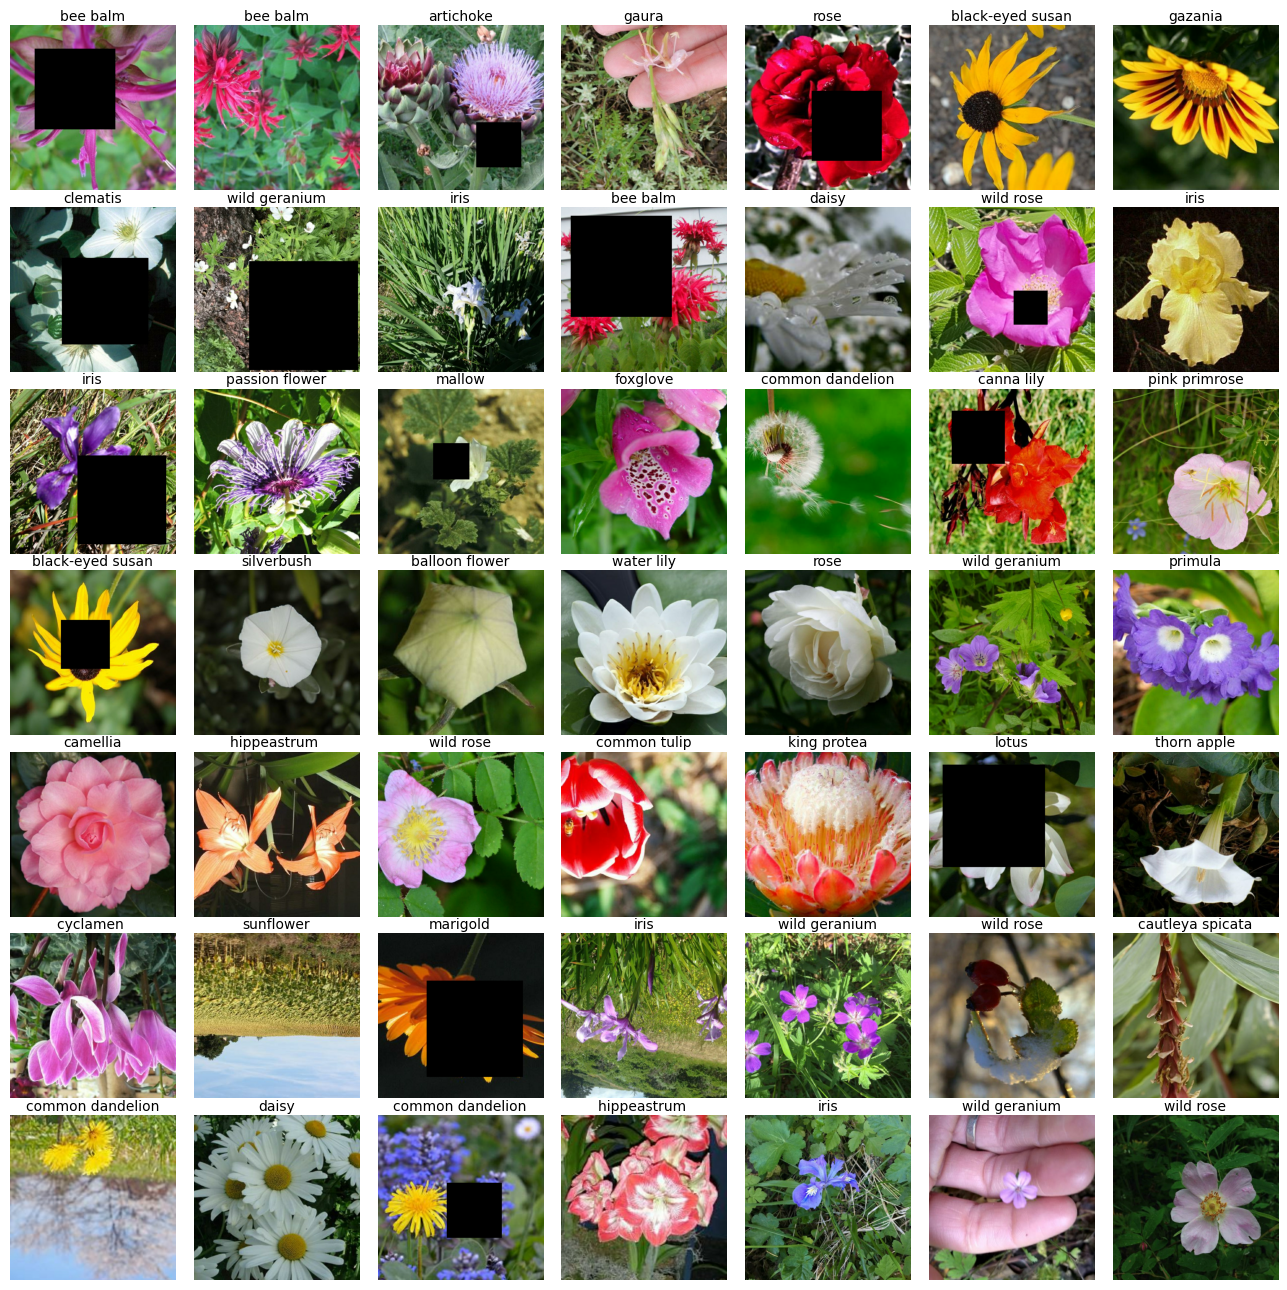

In [15]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

By defining `ds_iter` and `one_batch` in separate cells, you only need to rerun the cell above to see a new batch of images.

<a name="8"></a>
# 8. Define and Training Model #

## Learning Rate Schedule ##

We'll train this network with a special learning rate schedule.

In [16]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = MAX_LR,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

Now we're ready to create a neural network for classifying images! We'll use what's known as **transfer learning**. With transfer learning, we reuse part of a pretrained model to get a head-start on a new dataset.

The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define our model in a `strategy.scope()` context.

In [17]:
def get_fit_model(net, used_model, seed, weights):
    
    with strategy.scope():
        base_model = getattr(net, used_model)(
                        weights = weights,  
                        include_top=False,
                        input_shape=(*IMAGE_SIZE, 3))

        model = tf.keras.Sequential([
            base_model,
            # ... attach a new head to act as a classifier.
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])

        model.compile(
            optimizer='nadam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
        
        os.makedirs('checkpoints', exist_ok=True)

        checkpoint_callback = ModelCheckpoint(f'checkpoints/{used_model}_best.h5',
                               save_weights_only=True,
                               monitor='val_sparse_categorical_accuracy',
                               mode='max',
                               save_best_only=True,
                               verbose=1)

        best_epoch_callback = LambdaCallback(on_train_end=lambda logs: 
                                     print(f"Best val_sparse_categorical_accuracy: {checkpoint_callback.best:.4f}"))
        
    model.summary()
    
    history = model.fit(
        get_training_dataset(),
        validation_data=get_validation_dataset(),
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        callbacks=[lr_callback, checkpoint_callback, best_epoch_callback],
        verbose=1)
    model.load_weights(f'checkpoints/{used_model}_best.h5')
    
    return model, history

The `'sparse_categorical'` versions of the loss and metrics are appropriate for a classification task with more than two labels, like this one.

### Train model

In [18]:
model, history = get_fit_model(net_type, model_type, SEED, model_weights)

2023-11-10 00:59:17.637790: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:59:17.637883: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


83683744/83683744 [==============================] - 0s 0us/step


2023-11-10 00:59:25.421583: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:59:25.422319: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:59:25.422988: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:59:25.423550: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:59:25.424054: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:59:25.424573: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 00:59:25.425157: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 104)               213096    
                                                                 
Total params: 21074576 (80.39 MB)
Trainable params: 21020048 (80.19 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30


2023-11-10 01:00:01.527826: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-10 01:00:06.979496: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 01:00:06.980610: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 01:00:07.081154: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 01:00:07.082697: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 01:00:07.144917: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-10 01:00:07.145537: E ./tensorflow/compiler/xla/stream_executor/stream_

49/49 [==============================] - ETA: 0s - loss: 1.6863 - sparse_categorical_accuracy: 0.6322

2023-11-10 01:01:44.638650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.68777, saving model to checkpoints/Xception_best.h5
49/49 [==============================] - 153s 2s/step - loss: 1.6863 - sparse_categorical_accuracy: 0.6322 - val_loss: 1.2075 - val_sparse_categorical_accuracy: 0.6878 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000880000037997961.
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 0.4295 - sparse_categorical_accuracy: 0.8941
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.68777
49/49 [==============================] - 65s 1s/step - loss: 0.4295 - sparse_categorical_accuracy: 0.8941 - val_loss: 1.2852 - val_sparse_categorical_accuracy: 0.6786 - lr: 8.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000688000039048493.
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 0.2351 - sparse_categorical_accuracy: 0.9396
Epoch 3: val_sparse_categorical_accuracy improved from 0.68777 

This next cell shows how the loss and metrics progressed during training.

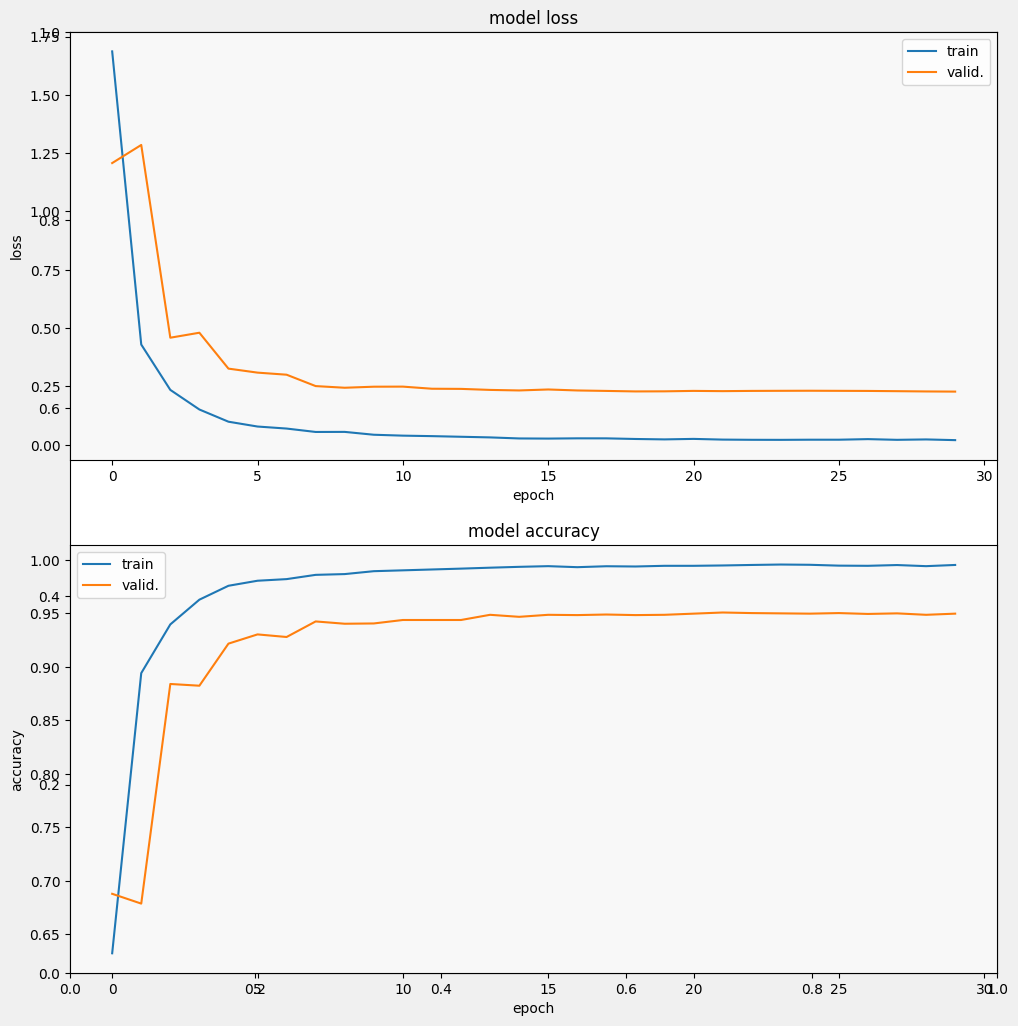

In [19]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

<a name="9"></a>
# 9. Evaluate Predictions #

Before making your final predictions on the test set, it's a good idea to evaluate your model's predictions on the validation set. This can help you diagnose problems in training or suggest ways your model could be improved. We'll look at two common ways of validation: plotting the **confusion matrix** and **visual validation**.

In [20]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

## Confusion Matrix ##

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) shows the actual class of an image tabulated against its predicted class. It is one of the best tools we have for evaluating the performance of a classifier.

The following cell does some processing on the validation data and then creates the matrix with the `confusion_matrix` function included in [`scikit-learn`](https://scikit-learn.org/stable/index.html).

In [21]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(cm_correct_labels,cm_predictions,labels=labels)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

2023-11-10 01:34:01.425851: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


15/15 [==============================] - 33s 1s/step


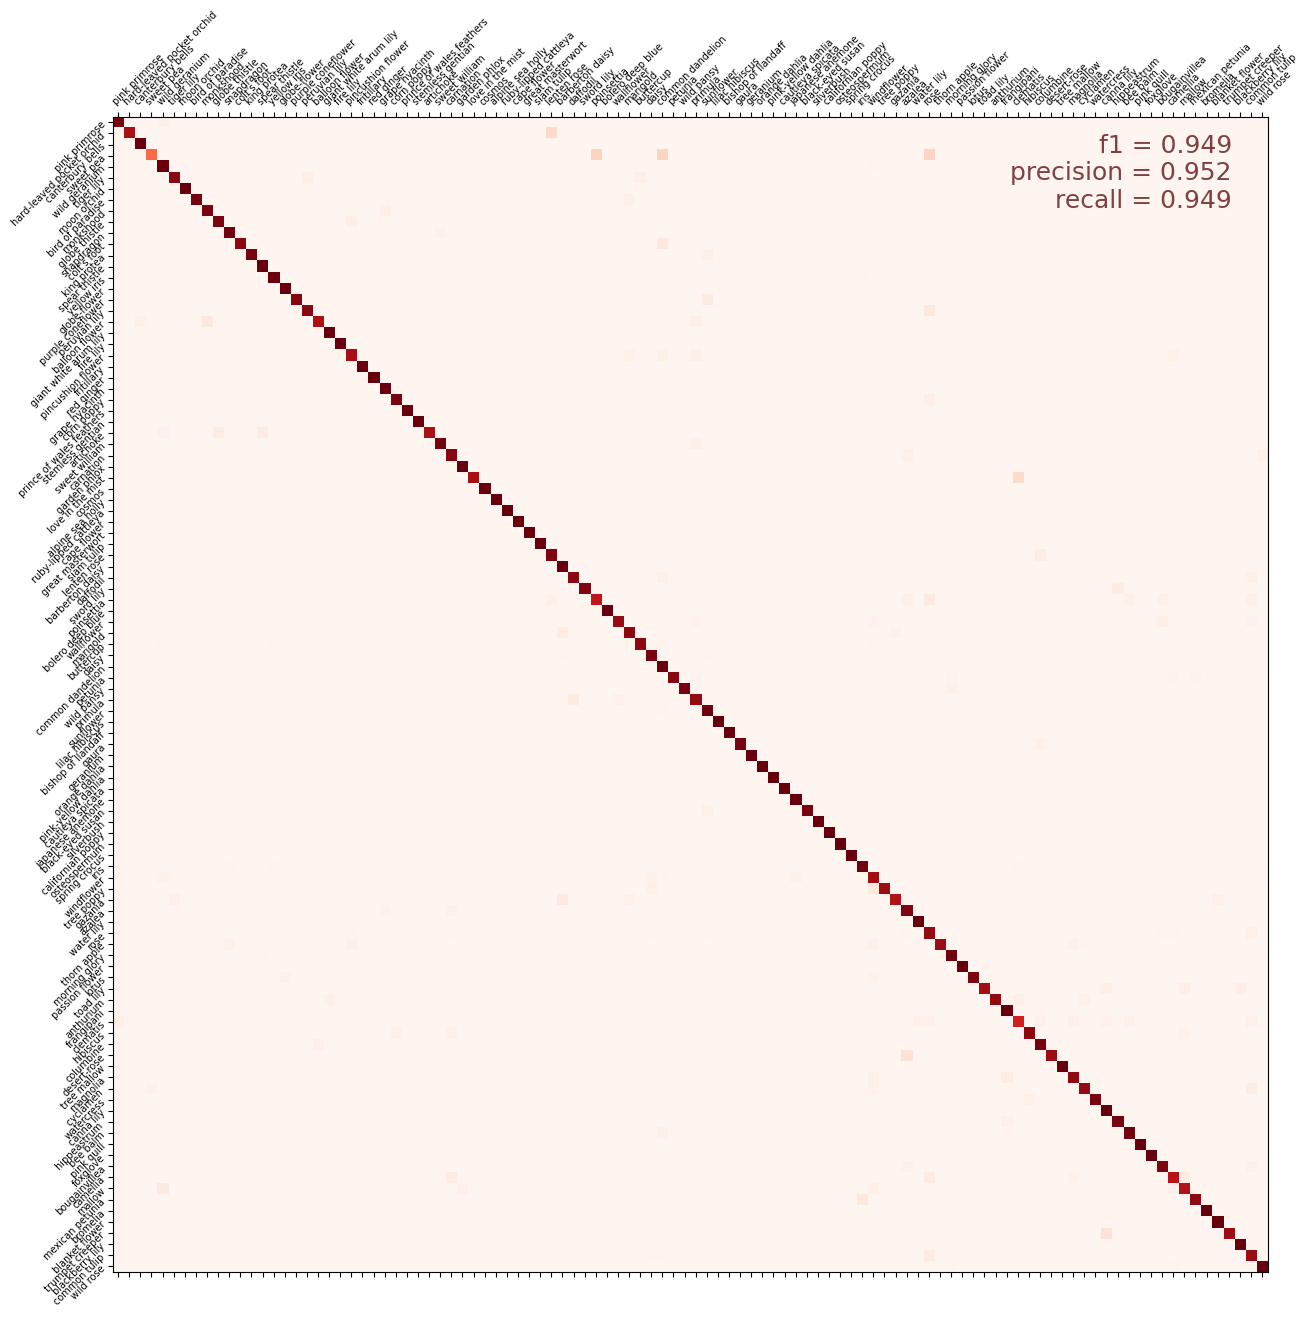

In [22]:
score = f1_score(cm_correct_labels, cm_predictions,labels=labels, average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=labels, average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=labels, average='macro')

display_confusion_matrix(cmat, score, precision, recall)

## Visual Validation ##

It can also be helpful to look at some examples from the validation set and see what class your model predicted. This can help reveal patterns in the kinds of images our model has trouble with.

This cell will set up the validation set to display 25 images at a time.

In [23]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(25)
batch = iter(dataset)

And here is a set of flowers with their predicted species. Run the cell again to see another set.

1/1 [==============================] - 9s 9s/step


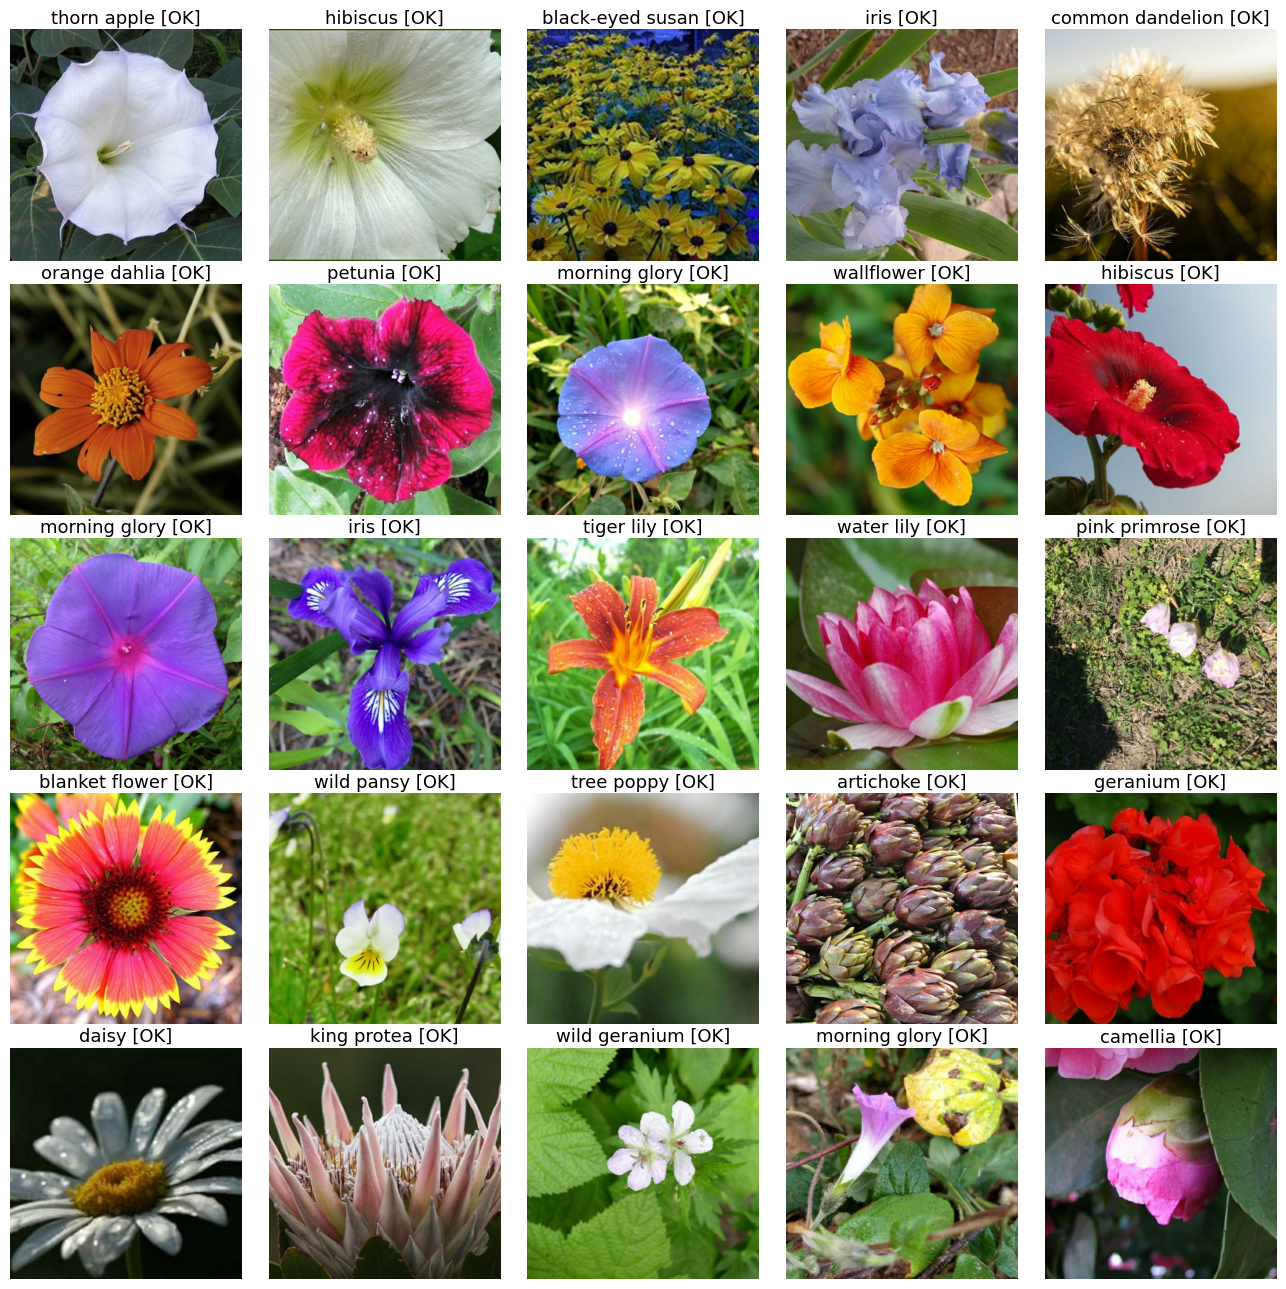

In [24]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

<a name="10"></a>
# 10. Make Test Predictions #

Once we're satisfied with everything, we're ready to make predictions on the test set.

In [25]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
29/29 [==============================] - 34s 1s/step
[ 24  83 103 ...  49  45  94]


We'll generate a file `submission.csv`. This file is what you'll submit to get your score on the leaderboard.

In [26]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
0b9afbdf2,24
c37a6f3e9,83
00e4f514e,103
1c4736dea,28
252d840db,67
dfc9c6a23,103
53cfc6586,29
541c4d41e,73
59d1b6146,46
